In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score
from sklearn import tree
from sklearn.metrics import confusion_matrix
import itertools
import re
import os
import pickle
from datetime import datetime

In [3]:
df_page = pd.read_csv('df_page.csv', dtype='object')
df = pd.read_csv('df.csv', dtype='object')

In [40]:
copy = df_page.copy()
copy2 = copy.sort_values('hitNumber', ascending=False).drop_duplicates(subset = 'fullVisitorId', keep = 'last')
#copy2 = copy.sort_values('hitNumber', ascending=False)
copy2.fillna(0, inplace=True)

In [41]:
copy2.drop(columns=['thankyou','dhealth_suc_s2','timeOnSite','health_yesno','prodgroup','prodgroup2','hitNumber','session_health','pathlastlv2',
                    'dhealth_thankyou','category','action','label','product_health','pathlastlv','pathlv1','pathlv2',
                    'pathlv3','pathlv4','visitId','date','hits_type','pagePath','nextTime','prevTime','timeOnPage','source','medium','campaign'],inplace=True)

In [42]:
train=copy2.sample(frac=0.8,random_state=200) #random state is a seed value
test=copy2.drop(train.index)

In [1]:
df_dummy = pd.get_dummies(train[['os','channelGrouping','source_new','medium_new']])

train_new = pd.concat([train, df_dummy], axis=1)
train_new.drop(columns=['os','channelGrouping','source_new','medium_new'],inplace=True)


In [62]:
clf = tree.DecisionTreeClassifier()
X = train_new.copy()
X = X.drop(columns=['fullVisitorId','health_suc_u'])
X = X.values.astype(float)
y = train_new['health_suc_u'].values.astype(int)

scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

#clf = XGBClassifier(n_estimators=100)
clf = clf.fit(X_train, y_train)

In [63]:
pd.options.display.float_format = '{:,.2f}'.format

importance = pd.DataFrame({'Feature':train_new.drop(columns=['fullVisitorId','health_suc_u']).columns.values, 'Importance':clf.feature_importances_})
importance.sort_values(by=['Importance'],ascending=[False],inplace=True)
print(importance[0:10])

# Confusion matrix 
y_pred = clf.predict(X_test)

print('')

print("Test Accuracy: ",round(accuracy_score(y_test,y_pred),2))
print("Test F1 Score: ",round(f1_score(y_test,y_pred),2))
print('')
print('')
print("Confusion Matrix on Test Data")
pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])

                Feature  Importance
2      page_per_session        0.14
3         page_per_user        0.14
8              prodview        0.11
1         session_visit        0.07
42  source_new_facebook        0.06
55     landing_d-health        0.06
0             day_visit        0.05
61      landing_maochai        0.03
33        day_Wednesday        0.03
29         day_Saturday        0.02

Test Accuracy:  0.99
Test F1 Score:  0.25


Confusion Matrix on Test Data


Predicted,0,1
Actual,,
0,85466,519
1,593,184


In [64]:
tmp = train_new.loc[(train_new['health_suc_u'] != 0)]

train_new = train_new.append([tmp])

In [67]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=12)
x_res, y_res = sm.fit_sample(X,y)

In [68]:

clf = tree.DecisionTreeClassifier()
X = train_new.copy()
X = X.drop(columns=['fullVisitorId','health_suc_u'])
X = X.values.astype(float)
y = train_new['health_suc_u'].values.astype(int)


scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=200)

sm = SMOTE(random_state=50)
x_res, y_res = sm.fit_sample(X_train, y_train)


#clf = XGBClassifier(n_estimators=100)
clf = clf.fit(x_res, y_res)

In [69]:
##random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score

clf_rf = RandomForestClassifier(n_estimators=25, random_state=12)
clf_rf.fit(x_res, y_res)

RandomForestClassifier(n_estimators=25, random_state=12)

In [70]:
pd.options.display.float_format = '{:,.2f}'.format

importance = pd.DataFrame({'Feature':train_new.drop(columns=['fullVisitorId','health_suc_u']).columns.values, 'Importance':clf.feature_importances_})
importance.sort_values(by=['Importance'],ascending=[False],inplace=True)
print(importance[0:10])

# Confusion matrix 
y_pred = clf.predict(X_test)

print('')

print("Test Accuracy: ",round(accuracy_score(y_test,y_pred),2))
print("Test F1 Score: ",round(f1_score(y_test,y_pred),2))
print('')
print('')
print("Confusion Matrix on Test Data")
pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])

                   Feature  Importance
8                 prodview        0.76
3            page_per_user        0.04
1            session_visit        0.03
64           landing_other        0.02
2         page_per_session        0.02
4           elite_thankyou        0.01
0                day_visit        0.01
60  landing_life-insurance        0.01
42     source_new_facebook        0.01
55        landing_d-health        0.01

Test Accuracy:  0.98
Test F1 Score:  0.54


Confusion Matrix on Test Data


Predicted,0,1
Actual,,
0,84276,1699
1,373,1224


In [121]:
predict_proba = clf_rf.predict_proba(X)
#predict = pd.DataFrame({‘fullVisitorId’:train_new[‘fullVisitorId’].values,‘predict_proba’:clf.predict(X) ,‘predict_roba’:[x[1] for x in predict_proba]})
predict = pd.DataFrame({'fullVisitorId':exp['fullVisitorId'].values ,'predict_roba':[x[1] for x in predict_proba]})
predict['fullVisitorId'] = predict['fullVisitorId'].astype(str)
predict

,fullVisitorId,predict_roba
0,7836639433449548012,0.00
1,3251089545148826979,0.00
2,3064470325624595274,0.00
3,2977516548053510452,0.00
4,2666493416117176268,0.00
...,...,...
88106,5635693363988957078,0.00
88107,7320002108086262326,0.00
88108,2611593387498164234,0.00
88109,8204149189283703047,0.00


<AxesSubplot:ylabel='Frequency'>

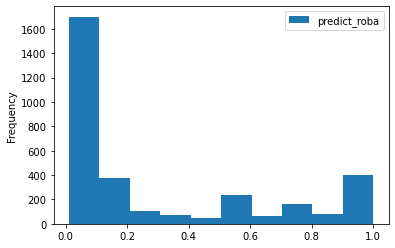

In [122]:
predict.loc[(predict['predict_roba'] >= 0.01)].sort_values('predict_roba').plot(kind = 'hist')

In [123]:
predict['potential'] = np.where(predict['predict_roba'] < 0.3, 'low',
                              np.where(predict['predict_roba'] > 0.6 , 'high', 'medium' ))


In [124]:
predict.groupby('potential')['potential'].count().nlargest(40)

potential
low       87047
high        704
medium      360
Name: potential, dtype: int64

In [125]:
success = ex_test.loc[(ex_test['health_suc_u'] == '1')].drop_duplicates('fullVisitorId')

In [126]:
success

,Unnamed: 0,fullVisitorId,visitId,date,pagePath,pathlv1,pathlv2,pathlv3,pathlv4,hitNumber,...,health_suc_u,thxu,dhealth_suc_s2,health_suc_s2,prodview,source_new,medium_new,landing,compare_suc,banner_dhealth
28,91,1711473417394560298,1603424731,20201023,/th/hospital-list,/th/,/hospital-list,NaN,NaN,9,...,1,1,1,1,2,facebook,other,NaN,0,0
200,891,6868149296321065179,1603350177,20201022,/th/payment-channels,/th/,/payment-channels,NaN,NaN,5,...,1,1,0,0,3,google,organic,NaN,0,0
205,900,6942118425682176787,1603567420,20201025,/th/retirement-insurance/return-retire?fbclid=...,/th/,/retirement-insurance/,/return-retire?fbclid=iwar1ghvn7q0sk8kh9j0dkfa...,NaN,1,...,1,1,0,0,3,facebook,other,return-retire,0,1
348,1724,3757314160389670898,1603422193,20201023,/en/thank-you?d-health=,/en/,/thank-you?d-health=,NaN,NaN,1,...,1,1,1,1,1,direct,none,other,0,0
390,1912,5063377023197519647,1603514257,20201024,/th/health-insurance/opd,/th/,/health-insurance/,/opd,NaN,1,...,1,1,0,0,2,google,organic,opd,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167427,71917,229353179355505286,1603756678,20201027,/en/whole-life-insurance,/en/,/whole-life-insurance,NaN,NaN,18,...,1,1,1,1,3,google,sem,NaN,0,0
168191,72682,5075279588750416923,1603874895,20201028,/th/about-mtl/news-and-update/open-time-branch,/th/,/about-mtl/,/news-and-update/,/open-time-branch,11,...,1,1,1,1,2,google,other,NaN,0,0
168274,72765,1520728289098212183,1603674966,20201026,/en/thank-you?d-health=,/en/,/thank-you?d-health=,NaN,NaN,3,...,1,1,1,1,2,google,other,NaN,0,0
168548,73039,7828866113849361389,1603702264,20201026,/th/thank-you?d-health=,/th/,/thank-you?d-health=,NaN,NaN,12,...,1,1,1,1,2,google,other,NaN,0,0


In [127]:
predict

,fullVisitorId,predict_roba,potential
0,7836639433449548012,0.00,low
1,3251089545148826979,0.00,low
2,3064470325624595274,0.00,low
3,2977516548053510452,0.00,low
4,2666493416117176268,0.00,low
...,...,...,...
88106,5635693363988957078,0.00,low
88107,7320002108086262326,0.00,low
88108,2611593387498164234,0.00,low
88109,8204149189283703047,0.00,low


In [128]:
predict['success'] = predict.fullVisitorId.isin(success.fullVisitorId).astype(int)

In [129]:
predict.groupby('success')['success'].count().nlargest(40)

success
0    87505
1      606
Name: success, dtype: int64